# House Price Prediction

In [ ]:
# Install libraries
!pip install -r requirements.txt

In [110]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import warnings

from sklearn.preprocessing import power_transform, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skew, kurtosis

## Data Review

### Load data

In [2]:
# Read data
df = pd.read_csv('data/data.csv')

### Examine the data

In [3]:
# Display dataframe head
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [4]:
# Shape of the dataset
print('Dataset rows: {}\nDataset columns: {}'.format(df.shape[0], df.shape[1]))

Dataset rows: 4600
Dataset columns: 18


### Use .info() to see length and dtypes

In [5]:
# General statistics on the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

**No NAs in the dataset. Date is not in correct format.**

In [6]:
# Update date format
df['date'] = pd.to_datetime(df['date'])

Min Date: 2014-05-02 00:00:00
Max Date: 2014-07-10 00:00:00


<AxesSubplot:>

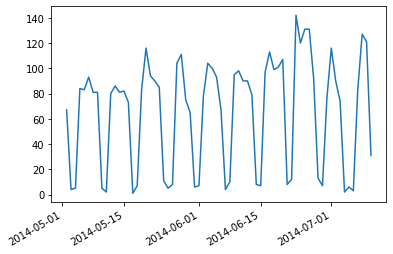

In [7]:
# Review date data
print('Min Date: {}'.format(df['date'].min()))
print('Max Date: {}'.format(df['date'].max()))
df['date'].value_counts().plot()

**The transactions are for between May and July. We don't need any date related values, so will drop this column.**

In [8]:
df.drop('date', axis=1, inplace=True)

### Check for duplicates

In [9]:
df.duplicated().sum()

0

### Identify numerical and categorical variables

In [10]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country'],
      dtype='object')

In [11]:
numeric_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
categorical_cols = ['waterfront', 'view', 'condition', 'street', 'city', 'statezip', 'country']

In [12]:
# Convert all categorical variables in string format 
for col in categorical_cols:
    df[col] = df[col].astype(str)

### Summarise numerical and categorical variables separately

In [13]:
# Describe numerical data
pd.set_option('float_format', '{:f}'.format)
df.describe(include = np.number)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated
count,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,551962.988473,3.400870,2.160815,2139.346957,14852.516087,1.512065,1827.265435,312.081522,1970.786304,808.608261
std,563834.702547,0.908848,0.783781,963.206916,35884.436145,0.538288,862.168977,464.137228,29.731848,979.414536
min,0.000000,0.000000,0.000000,370.000000,638.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,322875.000000,3.000000,1.750000,1460.000000,5000.750000,1.000000,1190.000000,0.000000,1951.000000,0.000000
50%,460943.461539,3.000000,2.250000,1980.000000,7683.000000,1.500000,1590.000000,0.000000,1976.000000,0.000000
75%,654962.500000,4.000000,2.500000,2620.000000,11001.250000,2.000000,2300.000000,610.000000,1997.000000,1999.000000
max,26590000.000000,9.000000,8.000000,13540.000000,1074218.000000,3.500000,9410.000000,4820.000000,2014.000000,2014.000000


**Minimum price is 0 that needs to be further investigated. There are houses with 0 bedrooms and bathrooms as well. Waterfront seems binary encoded. View and condition seem like ordinal variables.**

In [14]:
df.describe(include = ['O'])

,waterfront,view,condition,street,city,statezip,country
count,4600,4600,4600,4600,4600,4600,4600
unique,2,5,5,4525,44,77,1
top,0,0,3,2520 Mulberry Walk NE,Seattle,WA 98103,USA
freq,4567,4140,2875,4,1573,148,4600


**Waterfront and View are dominated by the most frequent variable. Street has more than 95% values unique and may not be useful on its own. USA is the only country in the dataset and can be removed.**

In [15]:
# Drop country
df.drop('country', axis=1, inplace=True)
categorical_cols.remove('country')

### Visualize target variable (price)

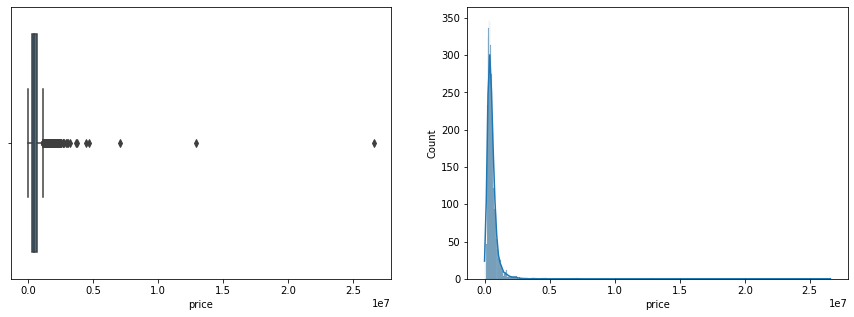

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=df, x = 'price', ax=ax[0])
sns.histplot(data=df, x = 'price', kde=True, ax=ax[1])
plt.show()

**We can see outliers in price above 0.7 million and can be further investigated**

In [17]:
# Check potential outliers on towards upper bound of boxplot
print(df[df['price'] > 1000000].shape)
df[df['price'] > 1000000].head()

(340, 16)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip
1,2384000.000000,5.000000,2.500000,3650,9050,2.000000,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119
11,1400000.000000,4.000000,2.500000,2920,4000,1.500000,0,0,5,1910,1010,1909,1988,3838-4098 44th Ave NE,Seattle,WA 98105
14,1200000.000000,5.000000,2.750000,2910,9480,1.500000,0,0,3,2910,0,1939,1969,3534 46th Ave NE,Seattle,WA 98105
99,1395000.000000,5.000000,3.500000,4010,8510,2.000000,0,1,5,2850,1160,1971,0,3930 NE Belvoir Pl,Seattle,WA 98105
107,1090000.000000,4.000000,2.500000,4340,141570,2.500000,0,0,3,4340,0,1992,0,8814 218th Ave NE,Redmond,WA 98053


**We can see above that some instances have high living square footage, high rating for view and condition, and/or have old vintage value.**

In [18]:
# Check potential outliers on towards upper bound of boxplot
print(df[df['price'] == 0].shape)
df[df['price'] == 0].head()

(49, 16)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip
4354,0.000000,3.000000,1.750000,1490,10125,1.000000,0,0,4,1490,0,1962,0,3911 S 328th St,Federal Way,WA 98001
4356,0.000000,4.000000,2.750000,2600,5390,1.000000,0,0,4,1300,1300,1960,2001,2120 31st Ave W,Seattle,WA 98199
4357,0.000000,6.000000,2.750000,3200,9200,1.000000,0,2,4,1600,1600,1953,1983,12271 Marine View Dr SW,Burien,WA 98146
4358,0.000000,5.000000,3.500000,3480,36615,2.000000,0,0,4,2490,990,1983,0,21809 SE 38th Pl,Issaquah,WA 98075
4361,0.000000,5.000000,1.500000,1500,7112,1.000000,0,0,5,760,740,1920,0,14901-14999 12th Ave SW,Burien,WA 98166


**As they have good condition rating and reasonable living space, the prices seem entry errors.**

In [19]:
# Remove outliers
df = df[(df['price'] > 7800) & (df['price'] < 1000000)]

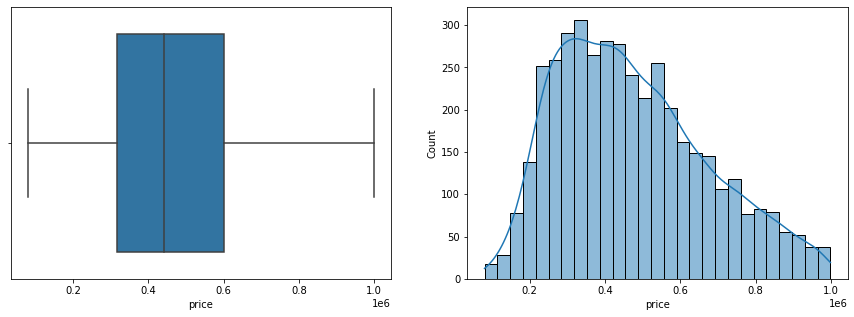

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=df, x = 'price', ax=ax[0])
sns.histplot(data=df, x = 'price', kde=True, ax=ax[1])
plt.show()

**Removing the outliers, we can see that the distribution is left skewed, and has an average house price of 470k, compared to 550k with outliers.**

### Visualizing dependent variables

In [21]:
def plot_feature(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # Variable distribution
    if df[col].dtype in ['int64', 'float64']:
        sns.histplot(data=df, x = col, ax=ax[0])
    else:
        df[col].value_counts().plot(ax=ax[0])
        
    # Variable relationship with target variable
    if df[col].dtype in ['int64', 'float64'] and col not in ['bedrooms', 'bathrooms', 'floors']:
        sns.regplot(data=df, x = col, y = 'price', scatter_kws={'alpha':0.3}, ax=ax[1])
    elif col in ['city', 'statezip']:
        sort_order = df.groupby(col)['price'].mean().sort_values(ascending=False).index
        sns.boxplot(data=df, x = col, y = 'price', order = sort_order, ax=ax[1])
    else:
        sns.boxplot(data=df, x = col, y = 'price', ax=ax[1])
    
    plt.xticks(rotation=45)
    plt.show()

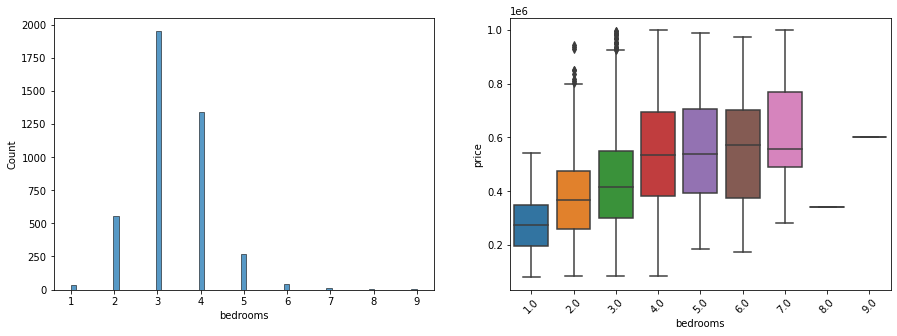

In [22]:
plot_feature(df, 'bedrooms')

**No. of bedrooms has a positive relationship with average price. Also, 6 or more are negligible compared to other measures.**

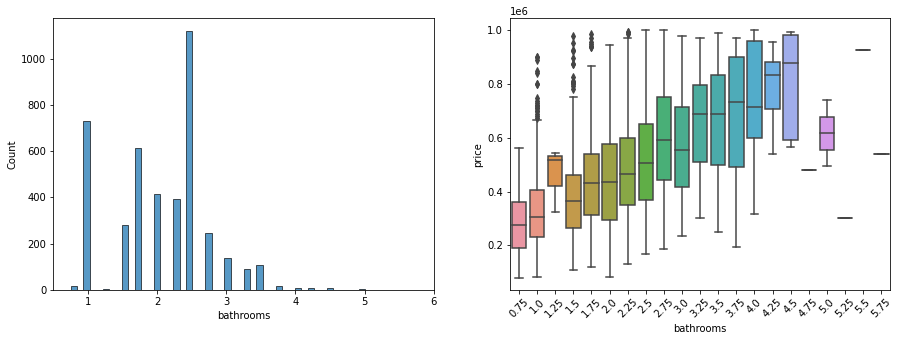

In [23]:
plot_feature(df, 'bathrooms')

**No. of bathrooms similarly has a positive relationship with average price. Value counts beyond 3 are negligible.**

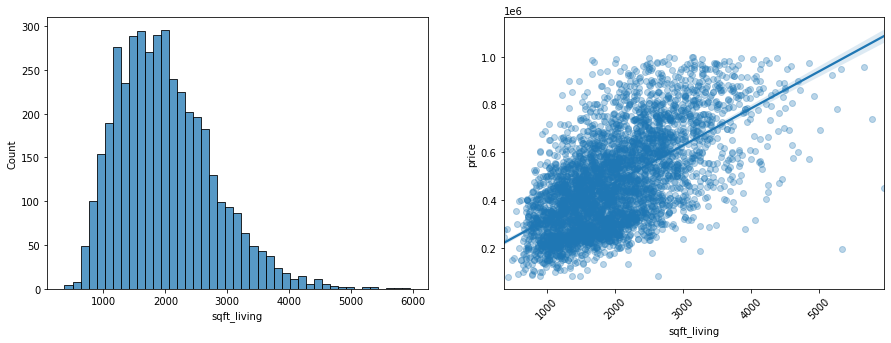

In [24]:
plot_feature(df, 'sqft_living')

**Living Area Square Footage has a positive relationship with house price.**

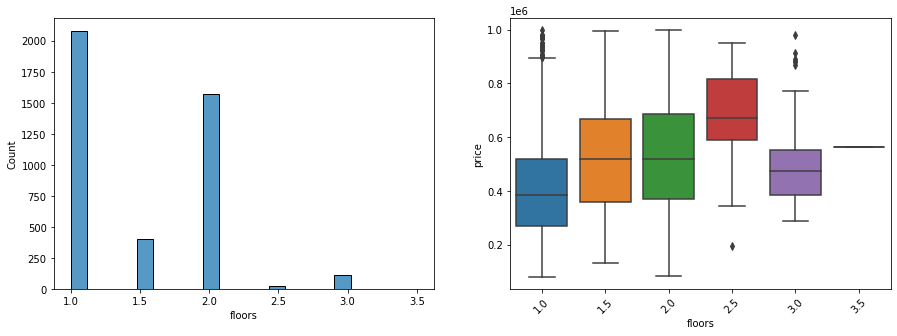

In [25]:
plot_feature(df, 'floors')

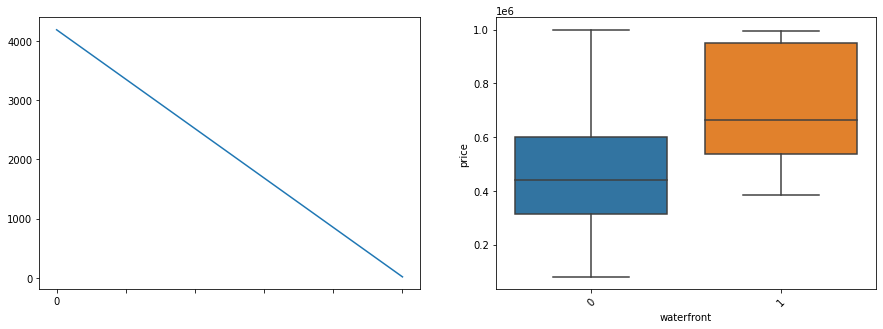

In [26]:
plot_feature(df, 'waterfront')

**There are only two values in waterfront, majority of them are 0.**

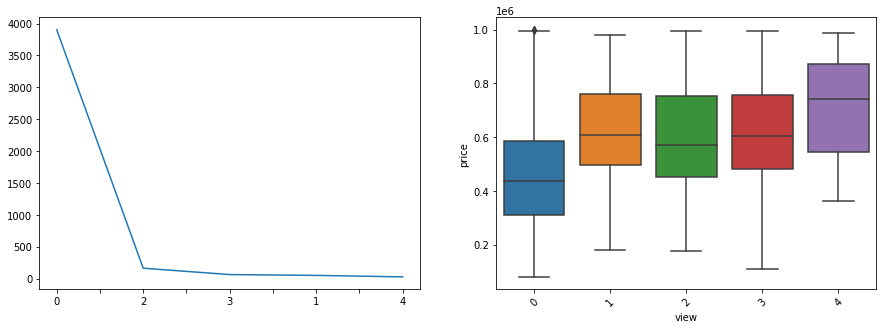

In [27]:
plot_feature(df, 'view')

**Majority of the view rankings are 0 and 1. We also see a relationship with average price.**

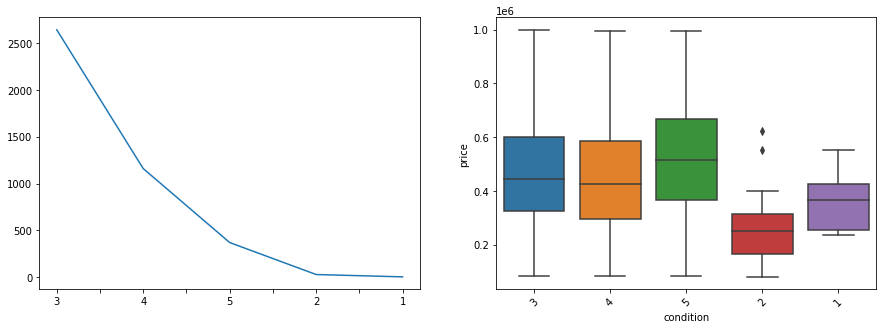

In [28]:
plot_feature(df, 'condition')

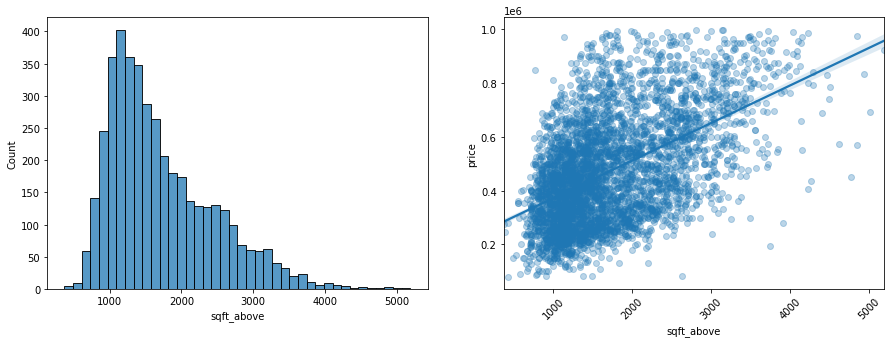

In [29]:
plot_feature(df, 'sqft_above')

**The plots above show a strong relationship between Above Ground Square Footage and house prices.**

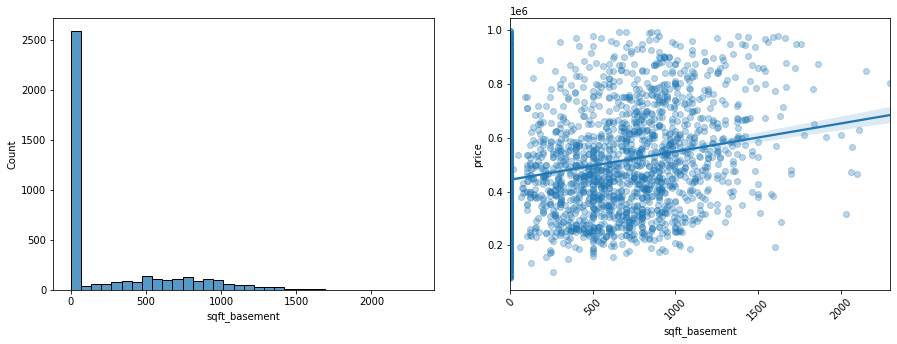

In [30]:
plot_feature(df, 'sqft_basement')

**Basement size does not have a strong relationship with price.**

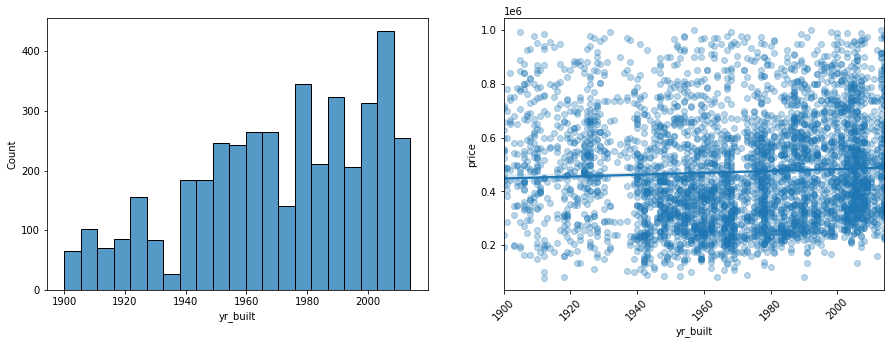

In [31]:
plot_feature(df, 'yr_built')

**We can vaguely see some non-linear relationship with Year Built and Price. The latest houses have higher price, but prior to 1940, the values seems to increase. This could be due to the size of the house, and also its vintage value. We also see less observations for older houses.**

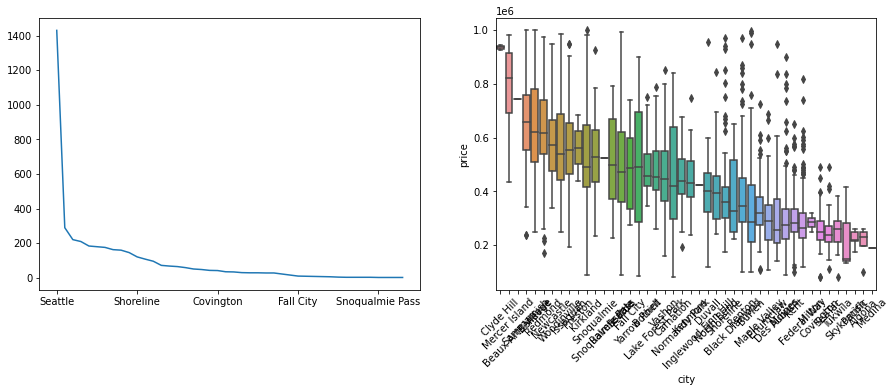

In [32]:
plot_feature(df, 'city')

**We can observe above that average prices vary across city and provide some insight on their values.**

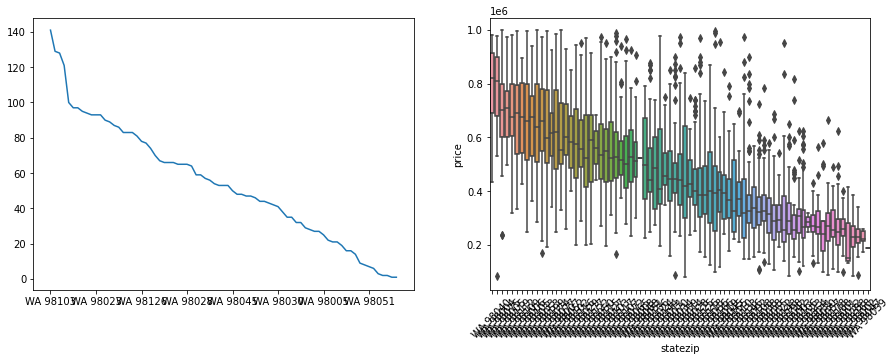

In [33]:
plot_feature(df, 'statezip')

**Similar trend is observed at zipcode level that can be utilized for estimate house prices.**

**Overall, we have notice skewed distributions for continuous variables, and power transformation may be useful for regression modelling.**

<AxesSubplot:>

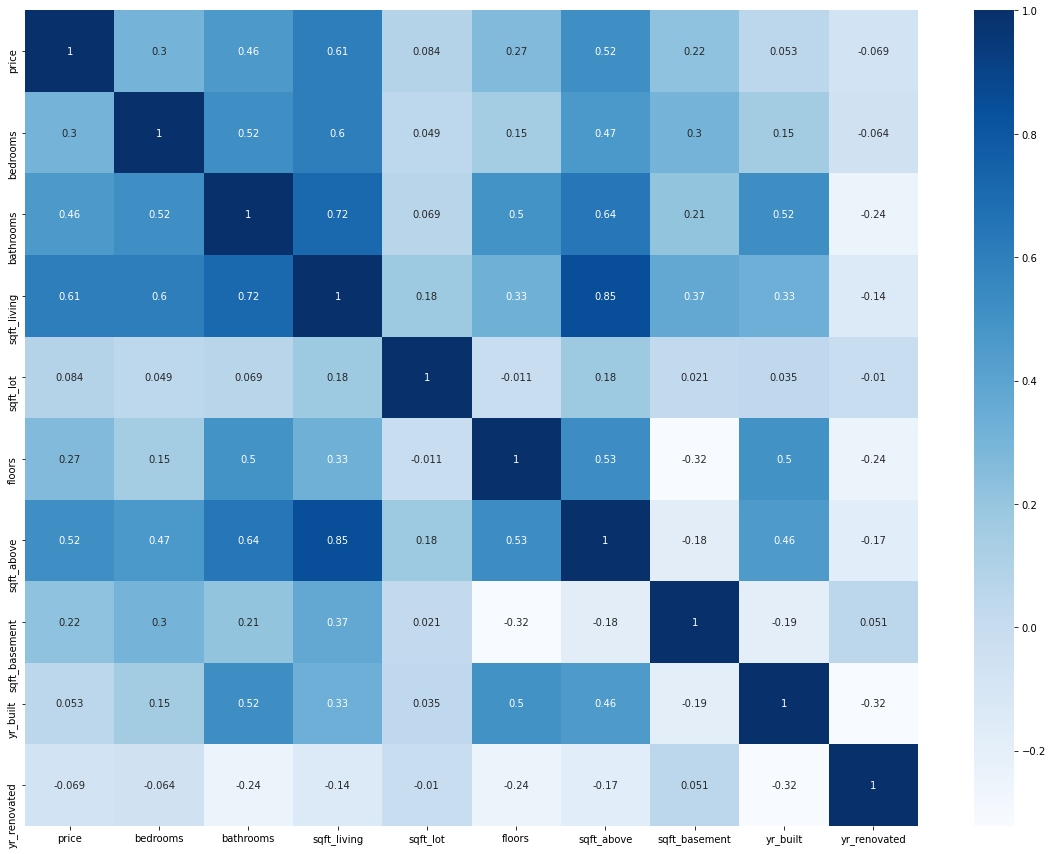

In [34]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), cmap='Blues', annot=True)

**The strongest correlation with price is with sqft_living at 0.61. sqft_living has a strong correlation with sqft_above and bathrooms at 0.85 and 0.72 respectively.**

## Modelling

In [126]:
class ModelContainer():
    '''The class implements the entire ML pipeline for predicting house prices'''
    def __init__(self, df):
        self.df = df.copy()
        self.num_vars = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
        self.cat_vars = ['waterfront', 'view', 'condition', 'statezip'] # street and city are excluded
        self.features = self.num_vars + self.cat_vars
        self.target = 'price'
        
        self.parameters = {'model__max_depth': [2, 4, 6, 8],
                           'model__min_samples_split': [5, 10, 15, 20, 30],
                           'model__random_state': [42]
                           }
        
    def split_data(self):
        # Split data into training and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df[self.features], self.df[self.target], test_size = 0.2, random_state=42)

        # Print dataframe shapes for train and test datasets
        print('Dataset Shapes ->')
        print('X_train: {}'.format(self.X_train.shape))
        print('y_train: {}'.format(self.X_test.shape))
        print('X_test: {}'.format(self.y_train.shape))
        print('y_test: {}'.format(self.y_test.shape))

    def create_transformer(self, print_df=False):
        # Transform categorical variables
        self.transformer = ColumnTransformer([
            ('tgt_enc', TargetEncoder(verbose=0), 'statezip'),
            ('ohe_enc', OneHotEncoder(), ['view', 'condition'])
        ],
        remainder='passthrough')
        self.transformer.fit(self.X_train, self.y_train)
        
        if print_df:
            # Display original data
            print('Training Dataset - Unprocessed')
            print(tabulate(self.X_train.head(), headers='keys', tablefmt='psql'))

            # Display transformed data
            preprocessed_data = pd.DataFrame(data=self.transformer.fit_transform(self.X_train, self.y_train), columns=self.transformer.get_feature_names())
            print('Training Dataset - Processed')
            print(tabulate(preprocessed_data.head(), headers='keys', tablefmt='psql'))

    def create_ml_pipeline(self):
        
        model = RandomForestRegressor()
        
        # Create ML pipeline
        self.pipeline = Pipeline([
            ('transformer', self.transformer),
            ('model', model)
        ])
    
    def train_model(self):
        # Run grid search on ML pipeline
        self.model = GridSearchCV(self.pipeline, param_grid=self.parameters, scoring='neg_root_mean_squared_error', cv=3)
        self.model.fit(self.X_train, self.y_train)
        
        print('Model training complete!')        

    def plot_feature_importance(self):
        # Show feature importances
        feature_importance = pd.Series(data = self.model.best_estimator_['model'].feature_importances_, index=self.transformer.get_feature_names()).sort_values()
        feature_importance.plot(kind='barh')
        plt.title('Feature Importance')
        plt.show()
        
    def plot_model_performance(self):
        # Plot model performance for training and test sets
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        
        preds = self.model.predict(self.X_train)
        ax[0].scatter(preds, self.y_train)
        ax[0].set_xlabel('Predicted Price')
        ax[0].set_ylabel('Actual Price')
        model_corr = round(np.corrcoef(preds, self.y_train)[0][1], 2)
        model_rmse = round(np.sqrt(mean_squared_error(self.y_train, preds)),2)
        ax[0].title.set_text('Training Set\nCorrelation: {}\nRoot Mean Squared Error: {}'.format(model_corr, model_rmse))
        
        preds = self.model.predict(self.X_test)
        ax[1].scatter(preds, self.y_test)
        ax[1].set_xlabel('Predicted Price')
        ax[1].set_ylabel('Actual Price')
        model_corr = round(np.corrcoef(preds, self.y_test)[0][1], 2)
        model_rmse = round(np.sqrt(mean_squared_error(self.y_test, preds)),2)
        ax[1].title.set_text('Test Set\nCorrelation: {}\nRoot Mean Squared Error: {}'.format(model_corr, model_rmse))
        
        plt.show()

Dataset Shapes ->
X_train: (3364, 13)
y_train: (842, 13)
X_test: (3364,)
y_test: (842,)


/Users/irtizak/.house-price-prediction/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/irtizak/.house-price-prediction/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/irtizak/.house-price-prediction/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/irtizak/.house-price-prediction/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif

Model training complete!


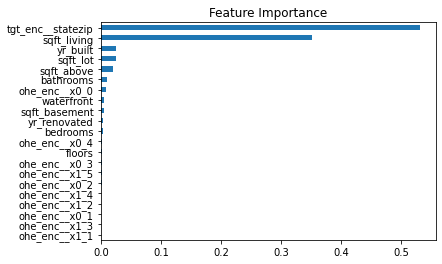

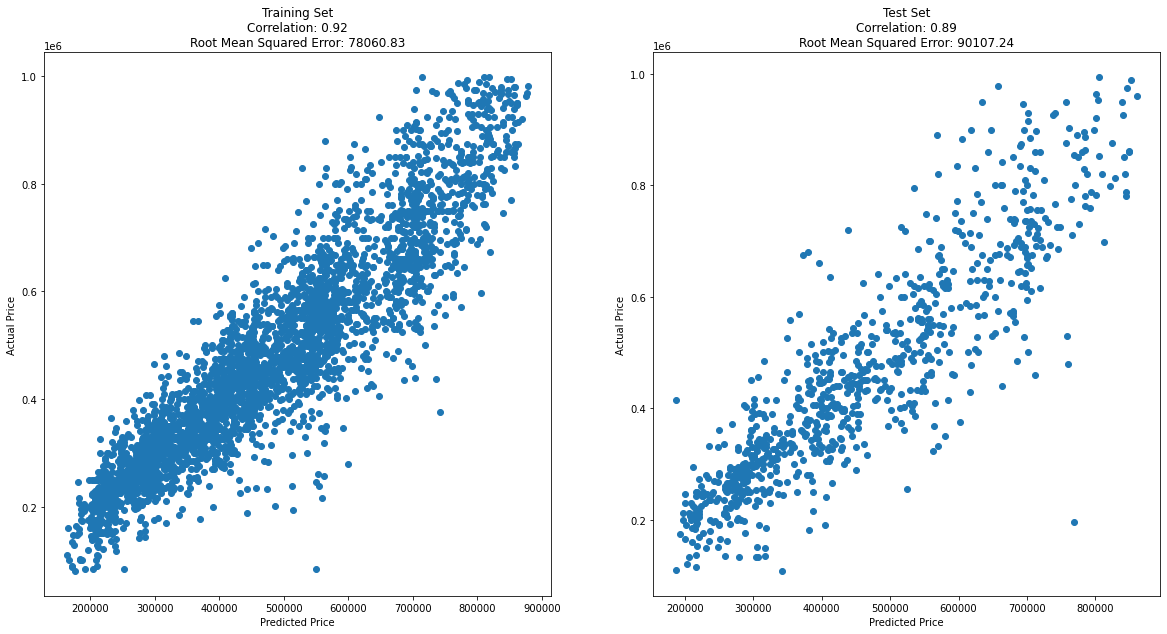

In [127]:
model = ModelContainer(df)

model.split_data()

model.create_transformer()

model.create_ml_pipeline()

model.train_model()

model.plot_feature_importance()

model.plot_model_performance()

In [ ]:
''' Next Steps:
- Review removed cases in more detail
- Review variable interactions in more detail e.g. impact of categorical and continuous variable interactions
- Review outliers in model performance.
- Consider binning variables with low frequency data.
- Experiment with polynomial features e.g. for bedrooms, average prices increase but gradually stabilize
'''